In [1]:
import os
import torch.nn as nn
import torch
from torch.nn import functional as F
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import torch.optim as optim

In [2]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
def check_tensor(tensor, name="Tensor"):
    if torch.isnan(tensor).any() or torch.isinf(tensor).any():
        raise ValueError(f"{name} contains NaN or Inf values.")

# 设置超参数
batch_size = 16
sequence_length = 30
d_model = 256
num_heads = 8
learning_rate = 1e-3
dropout = 0.1
n_layer = 6
dim_feedforward = 512
num_epochs = 50
num_features = 9
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
TORCH_SEED = 1337
torch.manual_seed(TORCH_SEED)

Using device: cuda:0


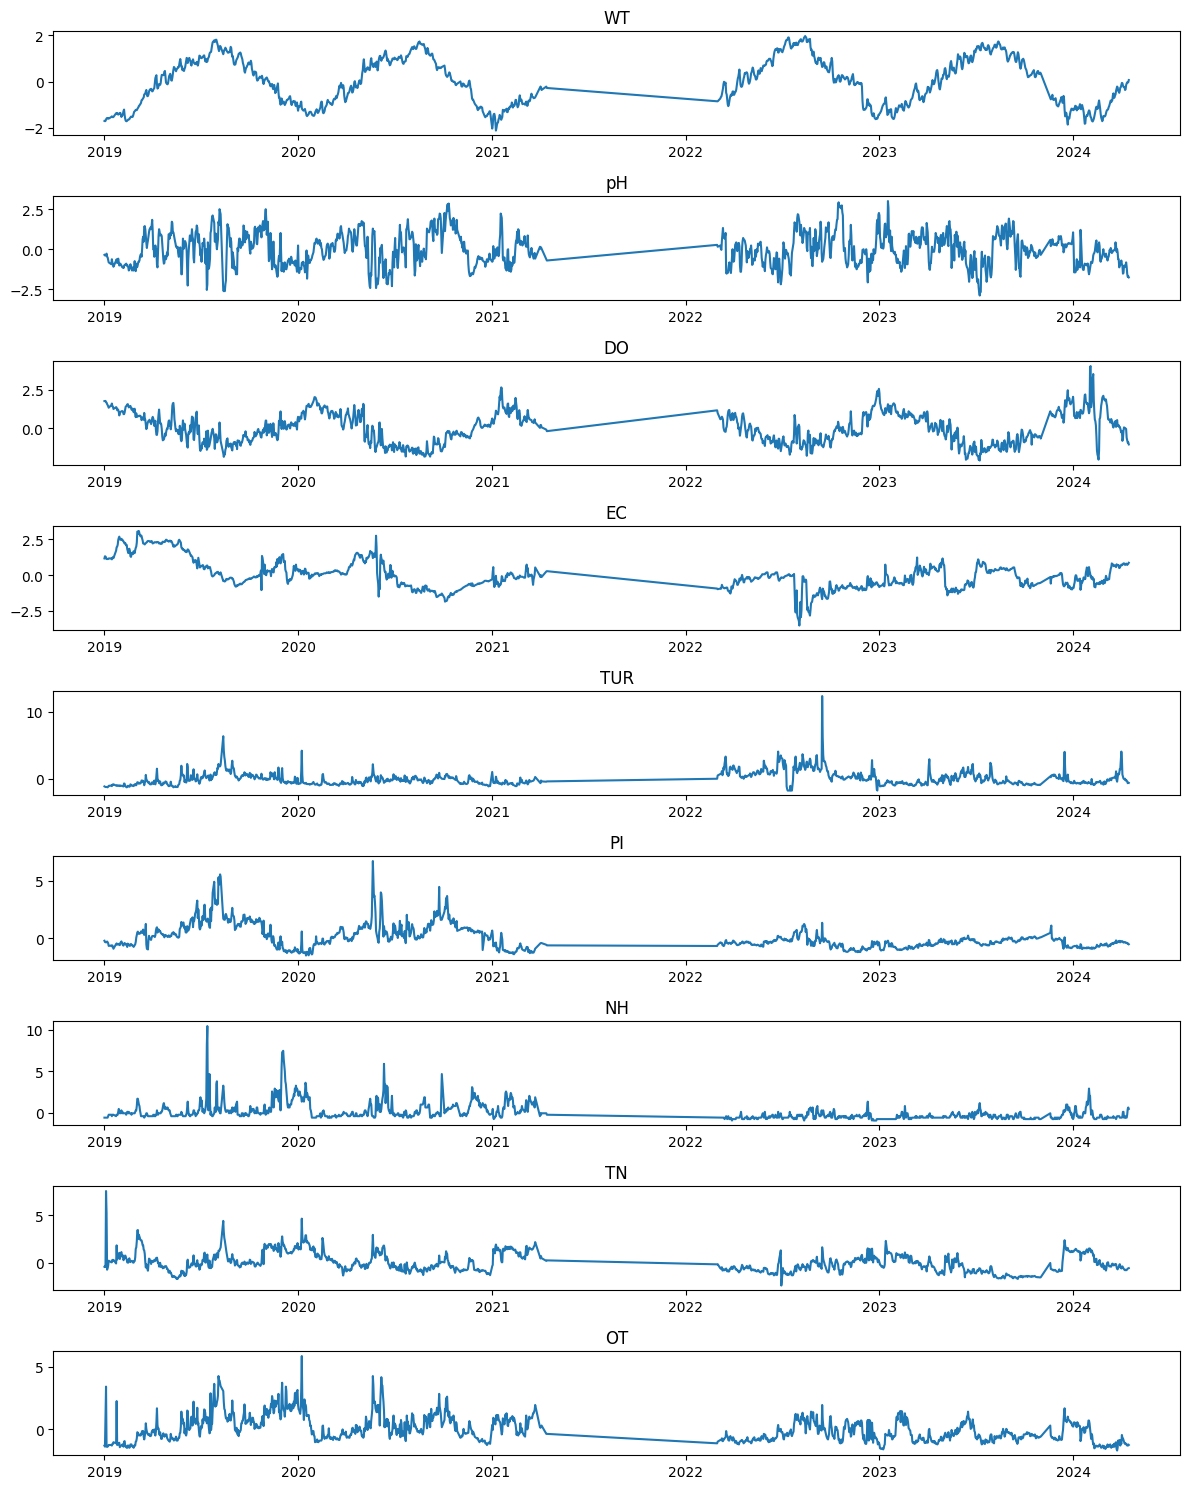

In [3]:
def load_data(corpus_path):
    corpus_df = pd.read_csv(corpus_path)
    corpus_df['date'] = pd.to_datetime(corpus_df['date'], format='%Y/%m/%d %H:%M')
    corpus_df.set_index('date', inplace=True)
    data_values = corpus_df.values
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data_values)
    return data_scaled, scaler, corpus_df.columns, corpus_df.index

# Load and scale your data
data_scaled, scaler, feature_names, data_index = load_data('C:/Users/11632/OneDrive/桌面/GPT/sequence_test/water.csv')

# Convert scaled data back to DataFrame for plotting
scaled_df = pd.DataFrame(data_scaled, columns=feature_names, index=data_index)

# Plotting each feature
plt.figure(figsize=(12, 15))
for i, feature in enumerate(feature_names):
    plt.subplot(len(feature_names), 1, i + 1)
    plt.plot(scaled_df.index, scaled_df[feature])
    plt.title(feature)
    plt.tight_layout()

plt.show()

# 创建输入序列和目标序列
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [61]:
corpus_path = 'C:/Users/11632/OneDrive/桌面/GPT/sequence_test/water.csv'
data_np, scaler,column,index = load_data(corpus_path)
x, y = create_sequences(data_np, sequence_length)
X_tensor = torch.tensor(x, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)
print(X_tensor.shape, y_tensor.shape)
# 定义数据集和数据加载器
dataset = TensorDataset(X_tensor, y_tensor)
train_size = int(0.9 * len(dataset))
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, len(dataset) - train_size])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset, batch_size=1, shuffle=False)
print("test_loader:",len(test_loader))

torch.Size([1485, 30, 9]) torch.Size([1485, 9])
test_loader: 1485


In [54]:
#FFN Layer
'''
Two Fully Connected Layers with ReLU Activation Function
'''
class Feedforward(nn.Module):
    def __init__(self, d_model):
        super(Feedforward, self).__init__()
        self.linear1 = nn.Linear(d_model, d_model * 4)
        self. relu = nn.ReLU()
        self.linear2 = nn.Linear(d_model * 4, d_model)
        self.dropout = nn.Dropout(dropout)


    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.dropout(x)
        
        return x
    
class Head(nn.Module):
    '''
    batch_size = 4
    context_size = 100
    d_model = 64
    '''
    def __init__(self,num_heads,head_size):
        super().__init__()
        # 64 * 64
        self.Wq = nn.Linear(d_model, head_size,bias = False)
        self.Wk = nn.Linear(d_model, head_size,bias = False)
        self.Wv = nn.Linear(d_model, head_size,bias = False)

        self.register_buffer('tril', torch.tril(torch.ones(sequence_length, sequence_length)))
        self.dropout = nn.Dropout(dropout)

    def forward(self,x):
        B,T,C = x.shape
        assert T <= sequence_length
        assert C == d_model
        Q = self.Wq(x)
        K = self.Wk(x)
        V = self.Wv(x)
        weight = Q @ K.transpose(-2, -1) * K.shape[-1]**-0.5

        weight = weight.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        weight = F.softmax(weight, dim=-1)
        weight = self.dropout(weight)
        output = weight @ V
        #print("Q shape:", Q.shape)
        #print("K shape:", K.shape)
        #print("Output of transpose operation:", K.transpose(-2, -1).shape)
        return output

class MultiHeadAttention(nn.Module):
    def __init__(self,num_heads,head_size):
        super().__init__()
        #recursively create num_heads heads
        self.heads = nn.ModuleList([Head(num_heads, head_size) for _ in range(num_heads)])
        #fc layer
        self.proj = nn.Linear(head_size * num_heads, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class Block(nn.Module):
    def __init__(self):
        super().__init__()
        head_size = d_model // num_heads
        self.ln1 = nn.LayerNorm(d_model)
        self.ln2 = nn.LayerNorm(d_model)
        self.multihead = MultiHeadAttention(num_heads, head_size)
        self.ffn = Feedforward(d_model)
        

    def forward(self, x):
        x = x + self.multihead(self.ln1(x))
        x = x + self.ffn(self.ffn(self.ln2(x)))
        return x
    
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, sequence_length):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(sequence_length, d_model)
        position = torch.arange(0, sequence_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

#define model
class Transformers(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature_projection = nn.Linear(num_features, d_model)
        self.position_embeddings = PositionalEncoding(d_model, sequence_length)
        self.blocks = nn.Sequential(*[Block() for _ in range(n_layer)])
        self.ln = nn.LayerNorm(d_model)
        self.fc = nn.Linear(d_model, num_features)
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, x):
        '''
        idx: [B, T] tensor of token indices, where B is batch size and T is sequence length.
        positions: [B, T] tensor of position indices corresponding to each token.
        '''
        #print("Shape of idx:", x.shape)
        B, T, F = x.shape

        x = self.feature_projection(x)  # Now [B, T, d_model]n
        x = self.position_embeddings(x)  # [B, T, d_model]
        
        # Step 2: Pass the combined embeddings through each of the transformer blocks
        x = self.blocks(x)  # Sequentially apply each Block
        
        # Step 3: Apply the final layer norm
        x = self.ln(x)  # [B, T, d_model]
        
        # Step 4 [B, d_model] -> [B, num_features]
        x = self.fc(x[:, -1, :])
        
        return x


In [77]:
input_tensor = X_tensor[0:1]
actual_output = y_tensor[0:1]
print(input_tensor.shape)
print(actual_output.shape)


torch.Size([1, 30, 9])
torch.Size([1, 9])


In [78]:
def test_model():
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print("Using device:", device)

    # Load model
    model = Transformers().to(device)
    try:
        model.load_state_dict(torch.load('model.pth', map_location=device))
        model.eval()

        # Ensure input data is available and move to the correct device
        input_tensor = X_tensor.to(device)
        actual_output = y_tensor.to(device)
        print("Input tensor shape:", input_tensor.shape)
        print("Actual output shape:", actual_output.shape)

        sequence_length = input_tensor.shape[1]
        batch_size = input_tensor.shape[0]
        num_features = input_tensor.shape[2]

        # Perform prediction
        predictions = []
        with torch.no_grad():
            for batch in test_loader:
                x_batch, y_batch = batch
                x_batch = x_batch.to(device)
                outputs = model(x_batch)
                predictions.extend(outputs.squeeze().tolist())

        predictions = np.array(predictions).reshape(batch_size, num_features)
        print("Predictions shape:", predictions.shape)

        # Ensure actual_output has the correct shape
        actual_output = actual_output[:predictions.shape[0]]
        print("Truncated actual output shape:", actual_output.shape)

        # Calculate loss for each feature across the batch
        loss = F.mse_loss(torch.tensor(predictions, device=device), actual_output, reduction='none').cpu().numpy()
        print("Loss shape:", loss.shape)

        # Plot loss for each feature across time steps
        for i in range(num_features):
            plt.figure(figsize=(10, 6))
            feature_loss = loss[:,i]  # Mean loss for feature i across all sequences
            plt.plot(range(len(feature_loss)), feature_loss, label=f'Feature {i + 1}')
            plt.xlabel('Time Step')
            plt.ylabel('MSE Loss')
            plt.title(f'MSE Loss for Feature {i + 1} Across Time Steps')
            plt.legend()
            plt.show()

    except RuntimeError as e:
        print("Error occurred:", e)

In [82]:
test_model()

Using device: cuda
Input tensor shape: torch.Size([1485, 30, 9])
Actual output shape: torch.Size([1485, 9])
Predictions shape: (1485, 9)
Truncated actual output shape: torch.Size([1485, 9])
Loss shape: (1485, 9)


AxisError: axis 1 is out of bounds for array of dimension 1

<Figure size 1000x600 with 0 Axes>

In [80]:
def train_model(model, train_loader, val_loader, num_epochs, learning_rate, save_path):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    for epoch in range(num_epochs):
        model.train()
        train_losses = []
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            # Generate position indices for each input batch
            sequence_length = inputs.shape[1]  # Assuming inputs are shaped as [B, T, F]
            
            optimizer.zero_grad()

            # Forward pass
            output = model(inputs)

            # Compute loss
            loss = criterion(output, targets)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {np.mean(train_losses):.4f}')

        # Validation phase
        model.eval()
        val_losses = []
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                output = model(inputs)
                loss = criterion(output, targets)
                val_losses.append(loss.item())

        print(f'Epoch [{epoch+1}/{num_epochs}], Validation Loss: {np.mean(val_losses):.4f}')

    # Save the model checkpoint
    torch.save(model.state_dict(), save_path)
    print(f'Model saved to {save_path}')


In [81]:
def main():
    action = "train"
    #input_dim = data_np.shape[1]  # 定义输入维度

    if action == 'train':
        model = Transformers().to(device)
        train_model(model, train_loader, val_loader, num_epochs, learning_rate, 'model.pth')
    

    else:
        print("Invalid action. Please enter 'train' or 'generate'.")

if __name__ == '__main__':
    main()

Epoch [1/50], Train Loss: 0.6972
Epoch [1/50], Validation Loss: 0.3239
Epoch [2/50], Train Loss: 0.3194
Epoch [2/50], Validation Loss: 0.2436
Epoch [3/50], Train Loss: 0.2605
Epoch [3/50], Validation Loss: 0.1855
Epoch [4/50], Train Loss: 0.2273
Epoch [4/50], Validation Loss: 0.1766
Epoch [5/50], Train Loss: 0.2202
Epoch [5/50], Validation Loss: 0.1718
Epoch [6/50], Train Loss: 0.2055
Epoch [6/50], Validation Loss: 0.1504
Epoch [7/50], Train Loss: 0.1998
Epoch [7/50], Validation Loss: 0.1565
Epoch [8/50], Train Loss: 0.1916
Epoch [8/50], Validation Loss: 0.1616
Epoch [9/50], Train Loss: 0.1921
Epoch [9/50], Validation Loss: 0.1614
Epoch [10/50], Train Loss: 0.1850
Epoch [10/50], Validation Loss: 0.1599
Epoch [11/50], Train Loss: 0.1813
Epoch [11/50], Validation Loss: 0.1520
Epoch [12/50], Train Loss: 0.1794
Epoch [12/50], Validation Loss: 0.1546
Epoch [13/50], Train Loss: 0.1735
Epoch [13/50], Validation Loss: 0.1431
Epoch [14/50], Train Loss: 0.1754
Epoch [14/50], Validation Loss: 0.1